# VR CO2 Study - Data processing

This notebook does the following:

1. x
2. y
3. z

Input: input
Output: output

In [4]:
# TODO
#1. Participant 1 CO2 mask data time is weird. First row of data in mask co2 df is '2022-04-27 17:50:59 UTC' while the file suggests it started 2022-04-27T19-55-22
#2 Participant 10 seems to have the same issue as P1 but generated fixed time csv. Still needs solving

In [5]:
# Imports
import os
if('notebooks' in os.getcwd()):
    os.chdir('..')
import json
import pandas as pd
from utils.constants import AirFiles, CO2Files, DATA_COLUMNS, FREQUENCIES
from utils.load_data import load_data_with_event_matching
from utils.timestamps import read_unix, read_j2000, j2000_to_unix, generate_biopac_unix_timestamps
from classes.Participant import Participant
from classes.DataHandler import DataHandler
import numpy as np
import matplotlib.pyplot as plt
from utils.plots import plot_eyetracking_filter, plot_participant_overview, plot_assess_filter
from utils.normalisation import eye_tracking as normalise_pupil_size
import math


In [6]:
# Open file index JSON for reading
file_index = pd.read_json(os.path.join(os.getcwd(), 'temp/file_index.json'))
file_index = file_index.sort_index()
participant_ids = file_index.index
participant_ids

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62],
           dtype='int64')

In [10]:
participant_ids = [30]
#participant_ids = [1,2,6,8,10,11,12,13,14,15,16,17,18,19,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,58,59,60,61,62]
synced_data_directory = os.path.join(os.getcwd(), 'temp', 'synced_participant_data')

Synced file for participant: 31_mohamed_lafi found. Loading existing file.


C:\Users\m\AppData\Local\Temp\ipykernel_9048\1346641064.py:10: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  participant.set_synced_data(pd.read_csv(synced_participant_file))


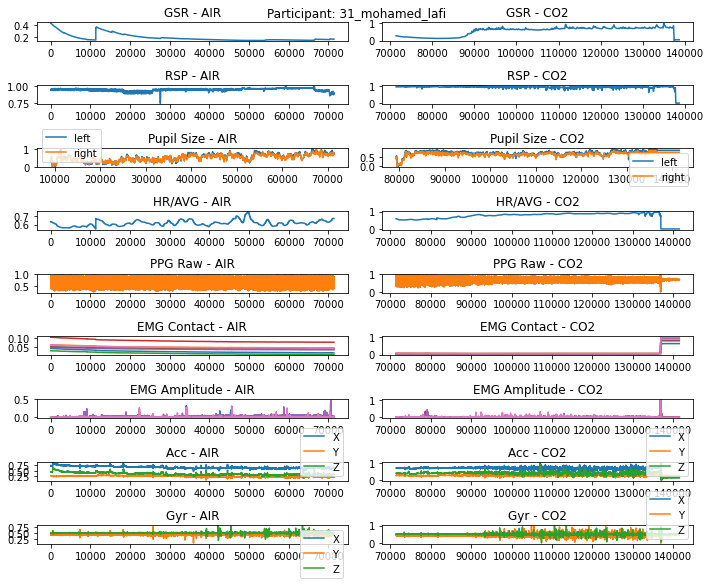

Features file found. Loading features file for participant: 31_mohamed_lafi
Extracting features for participant: 31_mohamed_lafi


C:\Users\m\anaconda3\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(
C:\Users\m\anaconda3\lib\site-packages\neurokit2\hrv\hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


Finished data processing for participant: 31_mohamed_lafi


In [11]:
# Loop that generates downsampled, synced files for every participant
for participant_id in participant_ids:
    participant_to_retrieve = participant_id
    participant_file_index = file_index[0][participant_to_retrieve]
    participant = Participant(participant_file_index['id'])
    
    synced_participant_file = os.path.join(synced_data_directory, str(participant.id)) + '.csv'
    if(os.path.exists(synced_participant_file)):
        print('Synced file for participant: ' + str(participant.id) + ' found. Loading existing file.')
        participant.set_synced_data(pd.read_csv(synced_participant_file))
    else:
        print('Generating new synced participant file for participant: ' + str(participant.id))
        
        # AIR
        if(participant_file_index[AirFiles.MASK.value] is None):
            print('Air mask file missing')
        else:
            print('Loading Air condition Data')
            air_mask_file = participant_file_index[AirFiles.MASK.value]
            air_event_file = participant_file_index[AirFiles.EVENT.value]
            air_eyetracking_file = participant_file_index[AirFiles.EYE.value]
            air_biopac_file = participant_file_index[AirFiles.BIOPAC.value]
            air_biopac_start_unix = participant_file_index[AirFiles.BIOPAC_UNIX_START_TIME.value]
            print(read_unix(air_biopac_start_unix))

            # Load mask data
            participant.set_air_mask_data(DataHandler.load_mask_data(air_mask_file, air_event_file, participant.id))
            # Load eye tracking data
            participant.set_air_eye_data(DataHandler.load_eyetracking_data(air_eyetracking_file, participant.id, 'air'))  
            # Load biopac data
            participant.set_air_biopac_data(DataHandler.load_biopac_data(air_biopac_file, air_biopac_start_unix, participant.id))  
            # Sync eye tracking and biopac data
            participant.set_air_synced_data(DataHandler.sync_signal_data(participant.air_mask_data, participant.air_eye_data, participant.air_biopac_data, air_biopac_start_unix))

        #CO2
        print('Loading CO2 condition Data')
        co2_mask_file = participant_file_index[CO2Files.MASK.value]
        co2_event_file = participant_file_index[CO2Files.EVENT.value]
        co2_eyetracking_file = participant_file_index[CO2Files.EYE.value]
        co2_biopac_file = participant_file_index[CO2Files.BIOPAC.value]
        co2_biopac_start_unix = participant_file_index[CO2Files.BIOPAC_UNIX_START_TIME.value]

        # Load mask data
        participant.set_co2_mask_data(DataHandler.load_mask_data(co2_mask_file, co2_event_file, participant.id))
        # Load eye tracking data
        participant.set_co2_eye_data(DataHandler.load_eyetracking_data(co2_eyetracking_file, participant.id, 'co2'))  
        # Load biopac data
        participant.set_co2_biopac_data(DataHandler.load_biopac_data(co2_biopac_file, co2_biopac_start_unix, participant.id))  
        # Sync eye tracking and biopac data
        participant.set_co2_synced_data(DataHandler.sync_signal_data(participant.co2_mask_data, participant.co2_eye_data, participant.co2_biopac_data, co2_biopac_start_unix))
    
        print('Downsampling and combining data')
        #Downsample and combine data. This data is also saved
        participant.set_synced_data(DataHandler.downsample_participant_data(participant.id, DataHandler.label_data(participant.air_synced_data), DataHandler.label_data(participant.co2_synced_data)))
    
    # Filter data
    filtered_data = DataHandler.filter_data(participant.synced_data)
    # Normalise data per participant
    normalised_data = DataHandler.normalise_data(filtered_data)
    
    plot_participant_overview(normalised_data, True)
    
    # Feature extraction
    windowed_features = DataHandler.extract_features(normalised_data)
    segment_features = DataHandler.extract_features_entire_condition(normalised_data)
    # ML
    print('Finished data processing for participant: ' + participant.id)



In [2]:
# Merge individual participant windowed feature files 
combined_features = DataHandler.merge_participant_windowed_feature_files()

In [12]:
# Merge individual participant segment feature files
combined_features = DataHandler.merge_participant_segment_feature_files()

In [ ]:
# Merge individual participant synced files into one file ('LARGE FILE')
#combined_signals = DataHandler.merge_participant_data_files()